In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pd.read_csv("wipro.csv")
data.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,03-01-2000,WIPRO,EQ,2522.40,2724.00,2724.20,2724.00,2724.20,2724.20,2724.17,1599,4.355940e+11,NaN,NaN,NaN
1,04-01-2000,WIPRO,EQ,2724.20,2942.15,2942.15,2942.15,2942.15,2942.15,2942.15,4392,1.292190e+12,NaN,NaN,NaN
2,05-01-2000,WIPRO,EQ,2942.15,2942.15,3177.55,2715.00,3000.00,2990.10,3063.86,132297,4.053390e+13,NaN,NaN,NaN
3,06-01-2000,WIPRO,EQ,2990.10,3144.70,3183.00,2790.00,2915.00,2932.25,2962.41,72840,2.157820e+13,NaN,NaN,NaN
4,07-01-2000,WIPRO,EQ,2932.25,2751.00,2751.00,2697.70,2697.70,2697.70,2697.95,10110,2.727630e+12,NaN,NaN,NaN


In [3]:
#feature extraction
data_final = data[["Date", "Open", "Close"]]
data_final['Date'] = pd.to_datetime(data_final['Date'], format = '%d-%m-%Y')
data_final.set_index(data_final['Date'], drop = True, inplace = True)
data_final = data_final[['Open', 'Close']]
data_final.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Open,Close
Date,,
2000-01-03,2724.00,2724.20
2000-01-04,2942.15,2942.15
2000-01-05,2942.15,2990.10
2000-01-06,3144.70,2932.25
2000-01-07,2751.00,2697.70


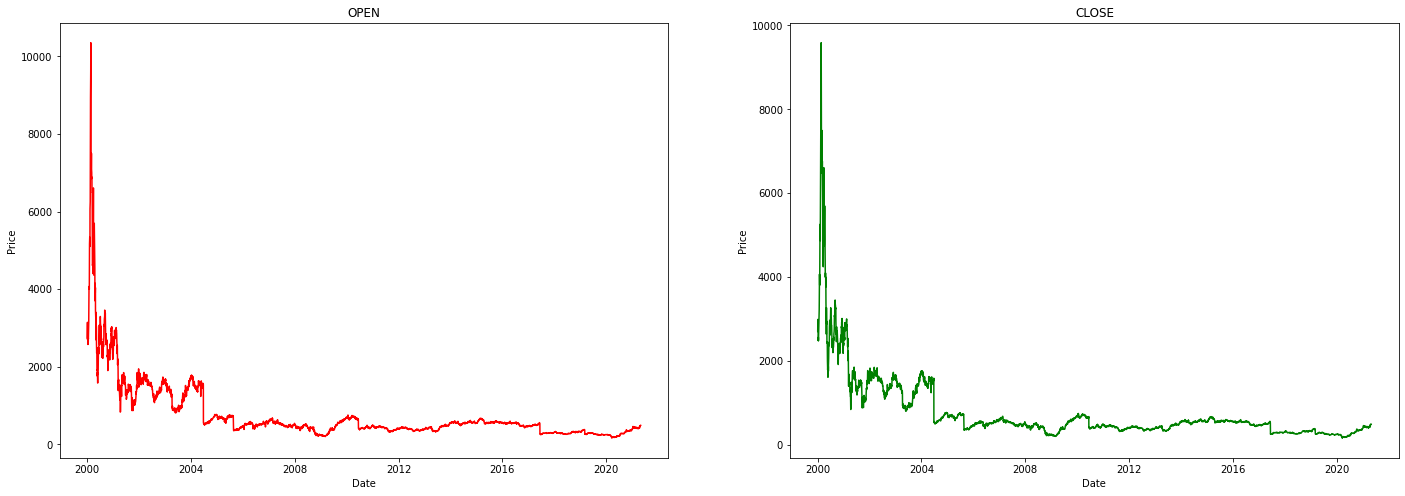

In [4]:
#visualisation
plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.title('OPEN')
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(data_final['Open'], color = 'red')
plt.subplot(1, 2, 2)
plt.title('CLOSE')
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(data_final['Close'], color = 'green')
plt.show()

In [5]:
scaler = MinMaxScaler()
data_final.loc[:, ["Open", "Close"]] = scaler.fit_transform(data_final.loc[:, ["Open", "Close"]])
data_final.head()

,Open,Close
Date,,
2000-01-03,0.251391,0.271811
2000-01-04,0.272806,0.294936
2000-01-05,0.272806,0.300023
2000-01-06,0.292690,0.293885
2000-01-07,0.254042,0.269000


In [6]:
#Train - Test split
train_len = round(len(data_final) * 0.7)
training_data = data_final[:train_len]
training_data.head()

,Open,Close
Date,,
2000-01-03,0.251391,0.271811
2000-01-04,0.272806,0.294936
2000-01-05,0.272806,0.300023
2000-01-06,0.292690,0.293885
2000-01-07,0.254042,0.269000


In [27]:
testing_data = data_final[train_len:]
testing_data.head()

,Open,Close
Date,,
2014-11-25,0.041318,0.044477
2014-11-26,0.041318,0.044291
2014-11-27,0.040901,0.044525
2014-11-28,0.041465,0.044928
2014-12-01,0.041710,0.045649


In [8]:
#Create training and testing seqeunces along with their prediction labels
def makeSeq(dataset):
  sequences = []
  labels = []
  starting = 0

  for stopping in range(50, len(dataset)): 
    sequences.append(dataset.iloc[starting : stopping])
    labels.append(dataset.iloc[stopping])
    starting += 1
  return (np.array(sequences).astype('float32'), np.array(labels).astype('float32'))

In [9]:
training_seq, training_labels = makeSeq(training_data)
testing_seq, testing_labels = makeSeq(testing_data)

In [10]:
print(np.shape(training_seq), np.shape(training_labels))
print(np.shape(testing_seq), np.shape(testing_labels))

(3664, 50, 2) (3664, 2)
(1542, 50, 2) (1542, 2)


In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [45]:
#LSTM Model
model = Sequential()
model.add(LSTM(50, input_shape = (training_seq.shape[1], training_seq.shape[2])))
model.add(Dropout(0.2))
#model.add(LSTM(50))
#model.add(Dropout(0.2))
model.add(Dense(2))
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = 'mean_absolute_error')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50)                10600     
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 102       
                                                                 
Total params: 10,702
Trainable params: 10,702
Non-trainable params: 0
_________________________________________________________________


In [46]:
history = model.fit(training_seq, training_labels, epochs = 80, verbose = 1, batch_size = 16, validation_data = (testing_seq, testing_labels))

Epoch 1/80
229/229 [==============================] - 5s 17ms/step - loss: 8.0249e-04 - mean_absolute_error: 0.0143 - val_loss: 3.7327e-05 - val_mean_absolute_error: 0.0056
Epoch 2/80
229/229 [==============================] - 3s 15ms/step - loss: 2.3204e-04 - mean_absolute_error: 0.0082 - val_loss: 1.3301e-05 - val_mean_absolute_error: 0.0032
Epoch 3/80
229/229 [==============================] - 3s 15ms/step - loss: 2.3705e-04 - mean_absolute_error: 0.0081 - val_loss: 1.8337e-05 - val_mean_absolute_error: 0.0038
Epoch 4/80
229/229 [==============================] - 3s 15ms/step - loss: 1.8869e-04 - mean_absolute_error: 0.0069 - val_loss: 8.0085e-06 - val_mean_absolute_error: 0.0023
Epoch 5/80
229/229 [==============================] - 3s 15ms/step - loss: 1.6591e-04 - mean_absolute_error: 0.0067 - val_loss: 6.5386e-06 - val_mean_absolute_error: 0.0022
Epoch 6/80
229/229 [==============================] - 3s 14ms/step - loss: 1.6146e-04 - mean_absolute_error: 0.0066 - val_loss: 4.8234e

Text(0, 0.5, 'Loss')

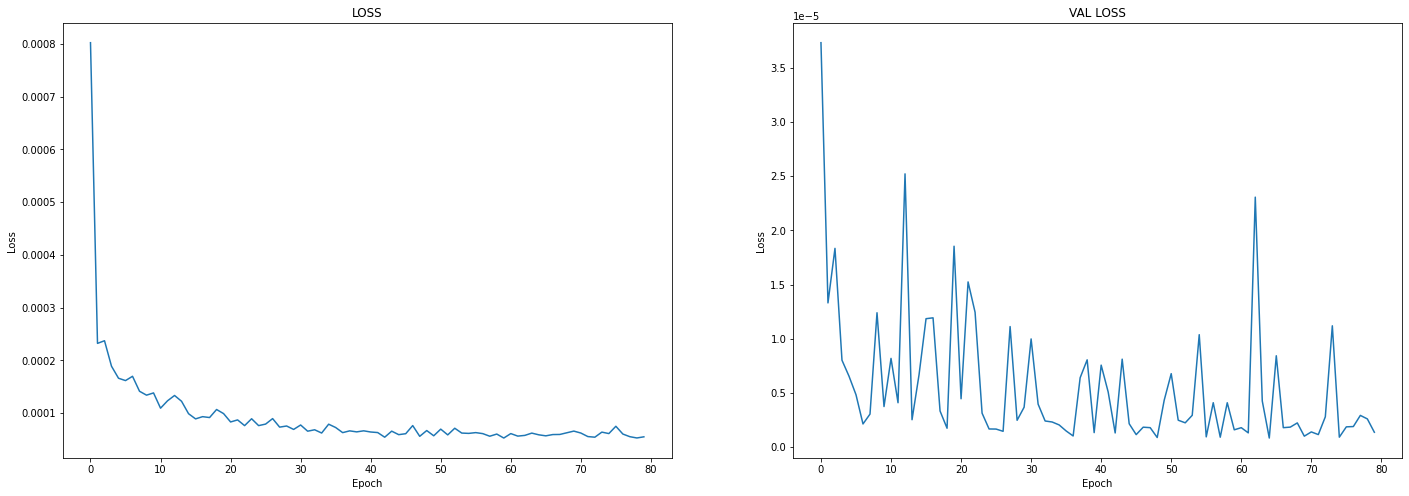

In [54]:
plt.figure(figsize = (24, 8))
plt.subplot(1, 2, 1)
plt.title('LOSS')
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.title('VAL LOSS')
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

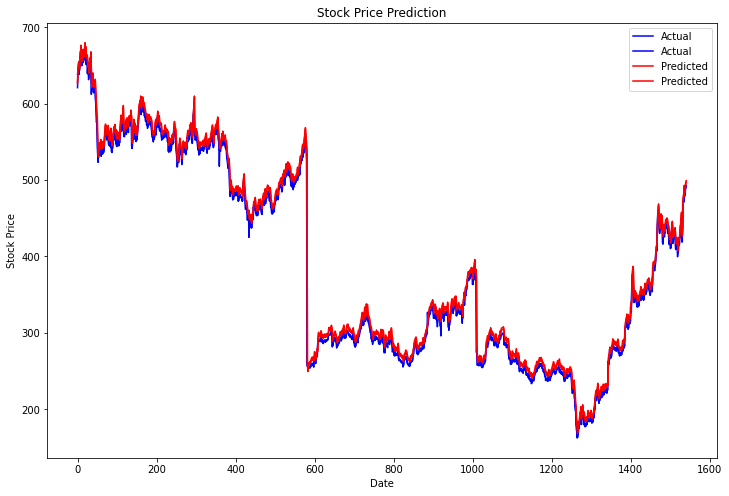

In [48]:
labels_predicted = model.predict(testing_seq)
labels_predicted = scaler.inverse_transform(labels_predicted)
plt.figure(figsize = (12, 8))
plt.plot(scaler.inverse_transform(testing_labels), color = 'blue', label = 'Actual')
plt.plot(labels_predicted , color = 'red', label = 'Predicted')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [49]:
score = model.evaluate(testing_seq, testing_labels, verbose = 1)

49/49 [==============================] - 0s 6ms/step - loss: 1.3572e-06 - mean_absolute_error: 7.9971e-04


In [50]:
mape = np.mean(np.abs(labels_predicted[:, 1].reshape(-1, 1) - scaler.inverse_transform(testing_labels)[:, 1].reshape(-1, 1)) / np.abs(scaler.inverse_transform(testing_labels)[:, 1].reshape(-1, 1)))
print('MAPE Open: '+str(mape))

MAPE Open: 0.020621916


In [51]:
mape = np.mean(np.abs(labels_predicted[:, 0].reshape(-1, 1) - scaler.inverse_transform(testing_labels)[:, 0].reshape(-1, 1)) / np.abs(scaler.inverse_transform(testing_labels)[:, 0].reshape(-1, 1)))
print('MAPE Close: '+str(mape))

MAPE Close: 0.025103716
